In [1]:
from tf_util_y import *
from DP import DataLoader
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [2]:
x1 = DataLoader(data_name = "FFBC400_8_",mode = 'ud',p_day = 50,train_prob = 0.95)
dd1 = x1(p_type="all")
x2 = DataLoader(data_name = "RH400_8_",mode = 'ud',p_day = 50,train_prob = 0.8)
dd2 = x2(p_type="all")
X_TR = np.concatenate((dd1["X_tr"],dd2["X_tr"]))
Y_TR = np.concatenate((dd1["Y_tr"],dd2["Y_tr"]))
# X_TR = dd2["X_tr"]
# Y_TR = dd2["Y_tr"]

In [3]:
class model3(MODEL):
    def __init__(self,**args):
        try:
            name = args["name"]
        except:
            name = "defmodel3"
        MODEL.__init__(self,name)
        self.X = tf.placeholder(shape=[None,50,50,18],dtype=tf.float32)
        self.Y = tf.placeholder(shape=[None,3],dtype=tf.float32)
        
        self.BNX = BN(self.X,name = self.name+"BNX")
        self.Z1 = CONV2D(self.BNX,[3,3,18,20],name=self.name+"Z1")
        self.A1 = ACT(PLUSB(self.Z1,name=self.name+"b1"),name=self.name+"A1")
        self.BNA1 = BN(self.A1,name=self.name+"BNA1")
        self.Z2 = CONV2D(self.BNA1,[5,5,20,25],name=self.name+"Z2")
        self.A2 = ACT(PLUSB(self.Z2,name=self.name+"b2"),name=self.name+"A2")
        self.BNA2 = BN(self.A2,name=self.name+"BNA2")
        
        self.PC0 = tf.nn.max_pool(self.BNA1,ksize=[1,4,4,1],strides=[1,4,4,1],padding="VALID")
        self.ZC0_1 = CONV2D(self.PC0,[3,3,20,30],name=self.name+"ZC0_1")
        
        self.PC1 = tf.nn.max_pool(self.BNA2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="VALID")
        self.ZC1_1 = CONV2D(self.PC1,[2,2,25,30],name=self.name+"ZC1_1")
        
        self.ZC = self.ZC0_1 + self.ZC1_1
        self.AC = ACT(PLUSB(self.ZC,name=self.name+"bC"),name=self.name+"AC")
        self.PCC1 = tf.nn.avg_pool(self.AC,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
        
        self.P1 = tf.nn.avg_pool(self.BNA2,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
        self.BNP1 = BN(self.P1,name=self.name+"BNP1")
        self.Z3 = CONV2D(self.BNP1,[3,3,25,30],name=self.name+"Z3")
        self.A3 = ACT(PLUSB(self.Z3,name=self.name+"b3"),name=self.name+"A3")
        self.BNA3 = BN(self.A3,name=self.name+"BNA3")
        self.PC2 = tf.nn.avg_pool(self.BNA3,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
        self.ZC2_1 = CONV2D(self.PC2,[3,3,30,30],padding="SAME",name=self.name+"ZC2_1")
        self.ACC = ACT(PLUSB(self.ZC2_1,name=self.name+"bCC"),name=self.name+"ACC")
        self.BNACC = BN(self.ACC,name=self.name+"BNACC")
        self.PCC2 = tf.nn.avg_pool(self.BNACC,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
        
        self.S0 = self.PCC1+self.PCC2
        self.AS0 = ACT(PLUSB(self.S0,name=self.name+"AS0"),name=self.name+"AS0")
        self.BNAS0 = BN(self.AS0,name=self.name+"BNAS0")
        self.ZS1 = CONV2D(self.BNAS0,[3,3,30,35],name=self.name+"ZS1")
        self.AS1 = ACT(PLUSB(self.ZS1,name=self.name+"bS1"),name=self.name+"AS1")
        self.BNAS1 = BN(self.AS1,name=self.name+"BNAS1")
        self.ZS2 = CONV2D(self.BNAS1,[3,3,35,40])
        
        self.F0 = tf.contrib.layers.flatten(self.ZS2)
        self.ZF1 = FC(self.F0,30,name=self.name+"ZF1")
        self.AF1 = ACT(PLUSB(self.ZF1,name=self.name+"bF1"),name=self.name+"AF1")
        self.BNAF1 = BN(self.AF1,name=self.name+"BNAF1")
        self.ZF2 = FC(self.BNAF1,10,name=self.name+"ZF2")
        self.AF2 = ACT(PLUSB(self.ZF2,name=self.name+"bF2"),name=self.name+"AF2")
        self.BNAF2 = BN(self.AF2,name=self.name+"BNAF2")
        self.ZF3 = FC(self.BNAF2,3,name=self.name+"ZF3")
        self.OUP = PLUSB(self.ZF3,name=self.name+"bOUP")
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.Y*100,self.OUP*100))
#         self.cost = tf.reduce_mean(
#             tf.nn.softmax_cross_entropy_with_logits(
#                 logits=self.OUP,
#                 labels=self.Y
#             )
#         )
        self.opt = tf.train.AdamOptimizer(0.02).minimize(self.cost)
        self.cp = tf.equal(tf.argmax(self.OUP),tf.argmax(self.Y))
        self.acc = tf.reduce_mean(tf.cast(self.cp,"float"))        

        
        self.init = tf.global_variables_initializer()
    def accuracy(self,X,Y):
        return self.acc.eval({self.X:X,self.Y:Y},session = self.sess)

In [19]:
tf.reset_default_graph()
m = model3()

In [103]:
from functools import reduce
def count_params():
    size = lambda v: reduce(lambda x, y: x*y, v.get_shape().as_list())
    n = sum(size(v) for v in tf.trainable_variables())
    print ("Model size: %dK" % (n/1000,))
    return n

In [20]:
m.open()

In [23]:
m.load()

INFO:tensorflow:Restoring parameters from defmodel3


<IPython.core.display.Javascript object>


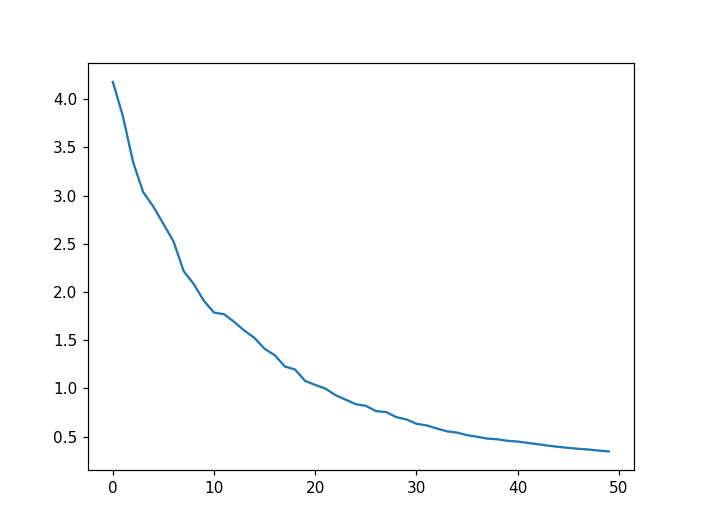

In [28]:
q = 320
m.train(X_TR[1+q:1+q+128,:,:,:],Y_TR[1+q:1+q+128,:],loop = 120)

In [7]:
# m.save()
m.close()

In [16]:
yy = dd2["Y_te"]

In [15]:
h = m.sess.run(m.OUP,feed_dict={m.X:dd2["X_te"]})

In [17]:
(np.argmax(h,axis=1) == np.argmax(yy,axis=1)).sum()/len(h)

0.38461538461538464

In [18]:
h.argmax(axis=1)

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       2, 1, 2, 2, 2, 2, 1, 2])

In [34]:
dd2["Y_tr"]

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ..., 
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

In [92]:
YY = m.sess.run(m.OUP,feed_dict={m.X:dd2["X_te"]})

In [93]:
abs(YY-yy)[:,0].mean(),abs(YY-yy)[:,1].mean(),abs(YY-yy)[:,2].mean()

(0.030993594883147624, 0.02210028262971811, 0.023174435873881981)

In [94]:
abs(YY-yy)[:,0].max(),abs(YY-yy)[:,1].max(),abs(YY-yy)[:,2].max()

(0.17266749306639087, 0.12984964436702082, 0.17857789939617552)

In [96]:
(abs(YY-yy)[:,0]<0.015).sum()/len(YY),(abs(YY-yy)[:,1]<0.015).sum()/len(YY),(abs(YY-yy)[:,2]<0.015).sum()/len(YY)

(0.28000000000000003, 0.4514285714285714, 0.44)

In [105]:
count_params()

Model size: 738K


738698